## notes

5/14/21, 1:57 PM currently this is broken even for data without contaminants. I'm not sure what is wrong.

6/23/21, 12:11 PM - gonna work on this. now it all seems to sample and work pretty much fine ignoring rounding (and indeed, even ignoring contaminants). Yet the real data is still entirely borked.

So returning to the strategy of trying to break things as the real data is breaking them, I'm not sure what to do exactly.  Added more noise and it is still sampling just fine.

And now I've checked with one block of the original data (exp2) and see that things still sample perfectly fine,  single trial vs average trial isn't the issue as I had originally expected. It really looks like it's MY DATA that is the problem.

In [62]:
import numpyro

numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist

from jax import numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive

# import pyro.infer
# import pyro.optim
# import pyro.distributions as dist
# from pyro.infer import Importance, EmpiricalMarginal

import numpy as np
import pandas as pd
import seaborn as sns
# import functools

import siuba as s
from siuba import _
# from dfply import *
%run -i 'model_helpers.py'
%run -i 'models.py'

## Simulate data

## create and fit model

Easiest to focus on fitting for a single participant

In [90]:
from numpy.random import default_rng

rng = default_rng(1)

def calc_prob_sim(trial, theta):
    ## compute implied subj. probability from latent theta and trial type
    ## this is a vectorized solution: https://bit.ly/2P6mMcD
    
    return trial_funcs[trial](theta)

def sim_sampling(prob, d, k):
    p_bs = calc_ptn_prob(prob, d)
    
    return rng.beta(p_bs*k, (1-p_bs)*k)


def sim_bayesian_sampler(trial_types, n_participants, n_blocks, params):
    from dfply import mutate, X
    n_trial_types = len(trial_types)
    trials = trial_types*n_blocks
    conds = np.tile(np.array(list(range(0,n_blocks))).repeat(len(trial_types)), n_participants)
    blocks = list(np.repeat(np.array(list(range(0, n_blocks))), n_trial_types))

    all_participants = list(np.repeat(np.array(list(range(0, n_participants))), n_trial_types*n_blocks))
    all_thetas = make_thetas(n_participants)
    all_trials = trials*n_participants
    all_blocks = blocks*n_participants

    sim_data = pd.DataFrame(
        data = {
            "ID": all_participants,
            "querytype": all_trials, 
            "block": all_blocks,
            "condition": conds
        }) >> mutate(
            conjdisj_trial = X.querytype.apply(is_conjdisj),
            d_base = X.ID.apply(lambda x: params["d_base"][x]),
            d_delta = X.ID.apply(lambda x: params["d_delta"][x]),
        theta = X.ID.apply(lambda x: all_thetas[x])
        ) >> mutate(d = X.d_base + X.d_delta * (1-X.conjdisj_trial))

    sim_data["prob"] = sim_data.apply(lambda x: calc_prob_sim(x.querytype, x.theta), axis=1)
    sim_data["response"] = sim_data.apply(lambda x: sim_sampling(x.prob, x.d, params["k"]), axis=1)
    
    return sim_data

# trial_types = list(num_vecs.keys())

## this is cut/pasted from my r-script, trial_types names are good
trial_types = [
    "A",
    "B",
    "notA",
    "notB",
    "AandB",
    "notAandB",
    "AandnotB",
    "notAandnotB",
    "AorB",
    "notAorB",
    "AornotB",
    "notAornotB",
    "AgB",
    "notAgB",
    "AgnotB",
    "notAgnotB",
    "BgA",
    "notBgA",
    "BgnotA",
    "notBgnotA"
    ]

N = 20
N_blocks = 4
params = {
    "d_base": rng.beta(1,1,N)/3.0,
    "d_delta":np.zeros(N),
    "k":5
}

print(params["d_base"])
sim_data = sim_bayesian_sampler(trial_types, n_participants=N, n_blocks=N_blocks, params=params)
sim_data = (
    sim_data >>
    s.ungroup() >>
    s.mutate(
        true_response = _.response,
        response = np.round(_.true_response*100)/100.
    ) >>
    s.mutate(response = _.response.replace({0:.001, 1:.999}))
)


print(sim_data.shape)
print(min(sim_data.response), max(sim_data.response))
sim_data.head()

[0.14138978 0.31741663 0.13356141 0.08318007 0.14560538 0.22051701
 0.27221641 0.02322781 0.29349478 0.23169765 0.0509611  0.0642589
 0.23371244 0.32492492 0.08394995 0.07929823 0.32003748 0.24298113
 0.26134921 0.30994839]
(1600, 12)
0.01 0.999


,ID,querytype,block,condition,conjdisj_trial,d_base,d_delta,theta,d,prob,response,true_response
0,0,A,0,0,0,0.14139,0.0,"[0.40770269954687377, 0.16801836067323794, 0.2...",0.14139,0.5757211,0.66,0.659092
1,0,B,0,0,0,0.14139,0.0,"[0.40770269954687377, 0.16801836067323794, 0.2...",0.14139,0.6153408,0.62,0.617066
2,0,notA,0,0,0,0.14139,0.0,"[0.40770269954687377, 0.16801836067323794, 0.2...",0.14139,0.42427894,0.82,0.820316
3,0,notB,0,0,0,0.14139,0.0,"[0.40770269954687377, 0.16801836067323794, 0.2...",0.14139,0.38465917,0.36,0.363067
4,0,AandB,0,0,1,0.14139,0.0,"[0.40770269954687377, 0.16801836067323794, 0.2...",0.14139,0.4077027,0.47,0.468357


In [91]:
X_data, y_data = make_model_data(sim_data) # see data_helpers.py

In [92]:

def prob_judge_BS(theta, X_num, X_denom, N, beta):

    pi = calc_prob(theta, X_num, X_denom)
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)
    
    return p_bs

def prob_judge_BS_d(theta, X_num, X_denom, d):

    pi = calc_prob(theta, X_num, X_denom)
    return calc_ptn_prob(pi, d)


def bayesian_sampler_simple(data, y=None):

    rounded_to = .01 # have modified  data so rounding is not important
    
    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    not_conjdisj = abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfCauchy(50)) # noise parameter

    with numpyro.plate("subj", n_Ps):
        ds = numpyro.sample("d_base", dist.Normal(0, 1.75))
        
    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))

    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]
    
    d_lin = ds[subj]
    d = sigmoid(d_lin)/3.
    
    p_bs = prob_judge_BS_d(theta, X_num, X_denom, d)
    
    # Likelihood
    with numpyro.plate("data", len(trial)):
        
        y_err = numpyro.sample("y_err", dist.Beta(1,1))
        y_err = (y_err - .50)*rounded_to
        
##        Gelman solution <-- pretty sure this is what is in stan manual
        # true_obs = y + y_err if y is not None else None
        true_obs = y if y is not None else None
        yhat = numpyro.sample("y_hat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=true_obs)
    
    return yhat

In [93]:
from numpyro.infer.initialization import init_to_value, init_to_feasible

mcmc_bs_simple = MCMC(NUTS(bayesian_sampler_simple, target_accept_prob=.90,
                          init_strategy = init_to_value(values={"y_err":.50})), 
               num_warmup=1_000, 
               num_samples=500, 
               num_chains=2)

mcmc_bs_simple.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [94]:
az_data_bs_simple = make_arviz_data(mcmc_bs_simple, bayesian_sampler_simple, X_data) # see model_helpers.py
print("num divergences =", count_divergences(az_data_bs_simple))
az.summary(az_data_bs_simple, var_names=['d_base', 'k'])

num divergences = 0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base[0],2.161,0.986,0.368,3.901,0.036,0.027,789.0,718.0,1.00
d_base[1],1.443,1.038,-0.359,3.383,0.046,0.033,502.0,815.0,1.00
d_base[2],0.083,0.593,-1.084,1.174,0.023,0.017,696.0,613.0,1.01
d_base[3],-0.269,0.934,-2.140,1.452,0.050,0.035,356.0,456.0,1.00
d_base[4],-0.301,0.521,-1.280,0.648,0.026,0.019,393.0,566.0,1.00
d_base[5],2.000,0.998,0.259,3.897,0.037,0.027,777.0,733.0,1.00
d_base[6],2.783,0.944,1.110,4.536,0.032,0.025,894.0,660.0,1.01
d_base[7],-1.762,0.614,-2.893,-0.767,0.029,0.021,465.0,580.0,1.01
d_base[8],0.572,0.552,-0.449,1.631,0.026,0.020,476.0,373.0,1.00
d_base[9],0.952,0.610,-0.040,1.945,0.034,0.027,498.0,332.0,1.00


<AxesSubplot:>

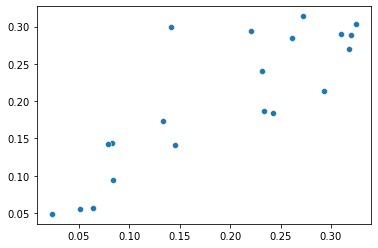

In [96]:
z = az.summary(az_data_bs_simple, var_names=['d_base', 'k'])
# print(params["d_base"])
sns.scatterplot(x = params["d_base"], y = sigmoid(z["mean"][0:N])/3.)

# breaking things

Adding 1% and 3% noise didn't seem to harm sampling nor estimates. Adding 10% noise breaks things. 

__rerunning__ 6/23/21, 12:46 PM: 5% noise also didn't cause problems and now seing that 10% isn't realy either, may be inducing some bias but obtained parameters still nicely correlated with the true parameters. even 20% doesn't wreck things, tho it biases K quite substantially.

Might also matter how many 0 and 1, a fully uniform noise pattern might be worse, but in practice people seem to avoid 0 and 1 so I am using a not-quite-uniform noise pattern.



In [84]:
# sim_data2 = sim_data
def round_to_p10(x):
    np.round(x*10)/10
    
sim_data2 = (
    sim_data >>
    s.ungroup() >>
    s.mutate(noise = rng.binomial(1, .07, size=len(sim_data))) >>
    s.mutate(true_response = _.response) >>
    s.mutate(response = s.if_else(_.noise==0, _.response, rng.beta(1.5,1.5,size=len(sim_data)))) >>
    s.mutate(
        # true_response = _.response,
        response = np.round(_.response*10)/10. # x100/100 make rounding unimportant
    ) >>
    s.mutate(response = _.response.replace({0:.001, 1:.999}))
)


print(sim_data2.shape)
print(min(sim_data2.response), max(sim_data2.response))
print(np.mean(sim_data2.noise))
sim_data2.head()

(1600, 13)
0.001 0.999
0.078125


,ID,querytype,block,condition,conjdisj_trial,d_base,d_delta,theta,d,prob,response,true_response,noise
0,0,A,0,0,0,0.14139,0.0,"[0.0237819282858509, 0.2546142068346184, 0.195...",0.14139,0.27839613,0.4,0.41,0
1,0,B,0,0,0,0.14139,0.0,"[0.0237819282858509, 0.2546142068346184, 0.195...",0.14139,0.21919668,0.3,0.32,0
2,0,notA,0,0,0,0.14139,0.0,"[0.0237819282858509, 0.2546142068346184, 0.195...",0.14139,0.7216039,0.9,0.91,0
3,0,notB,0,0,0,0.14139,0.0,"[0.0237819282858509, 0.2546142068346184, 0.195...",0.14139,0.7808033,0.7,0.68,0
4,0,AandB,0,0,1,0.14139,0.0,"[0.0237819282858509, 0.2546142068346184, 0.195...",0.14139,0.02378193,0.2,0.20,0


<AxesSubplot:ylabel='Count'>

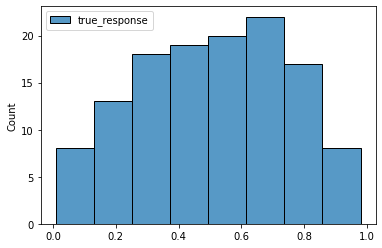

In [85]:
sns.histplot(sim_data2 >> s.filter(_.noise==1) >> s.select(_.true_response))

In [86]:
X_data2, y_data2 = make_model_data(sim_data2) # see data_helpers.py
print(len(y_data2), "observations")

1600 observations


In [87]:
from numpyro.infer.initialization import init_to_value, init_to_feasible

mcmc_bs_simple = MCMC(NUTS(bayesian_sampler_simple, target_accept_prob=.90,
                          init_strategy = init_to_value(values={"y_err":.50})), 
               num_warmup=500, 
               num_samples=500, 
               num_chains=2)

mcmc_bs_simple.run(random.PRNGKey(0), X_data2, y_data2)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [88]:
az_data_bs_simple = make_arviz_data(mcmc_bs_simple, bayesian_sampler_simple, X_data2) # see model_helpers.py
print("num divergences =", count_divergences(az_data_bs_simple))
az.summary(az_data_bs_simple, var_names=['d_base', 'k'])

num divergences = 0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base[0],0.384,0.528,-0.581,1.409,0.022,0.016,619.0,624.0,1.00
d_base[1],1.775,1.095,0.019,3.943,0.051,0.036,481.0,617.0,1.00
d_base[2],-1.972,0.761,-3.474,-0.767,0.036,0.027,491.0,555.0,1.00
d_base[3],-0.594,0.757,-1.893,0.763,0.055,0.039,218.0,436.0,1.00
d_base[4],-1.090,0.322,-1.739,-0.515,0.014,0.010,560.0,563.0,1.00
d_base[5],-0.220,0.440,-1.090,0.535,0.016,0.013,748.0,741.0,1.00
d_base[6],0.885,0.636,-0.458,2.053,0.034,0.027,390.0,203.0,1.00
d_base[7],-2.932,0.928,-4.704,-1.353,0.035,0.026,754.0,411.0,1.00
d_base[8],1.911,0.789,0.656,3.647,0.030,0.023,757.0,573.0,1.00
d_base[9],2.843,0.905,1.237,4.482,0.037,0.028,674.0,496.0,1.00


<AxesSubplot:>

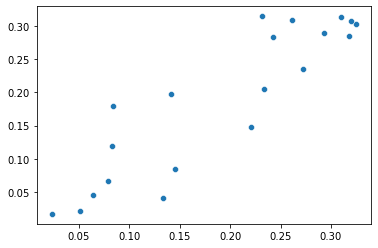

In [89]:
z = az.summary(az_data_bs_simple, var_names=['d_base', 'k'])
# print(params["d_base"])
sns.scatterplot(x = params["d_base"], y = sigmoid(z["mean"][0:N])/3.)

# mixture modeling (garbage collection)

In [55]:
def bayesian_sampler_simple_mix(data, y=None):

    rounded_to = .01
    
    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds, n_obs = np.unique(subj).shape[0], np.unique(cond).shape[0], subj.shape[0]
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    not_conjdisj = abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfCauchy(50)) # noise parameter
    
    mixing_probs = numpyro.sample("mixing", dist.Dirichlet(jnp.ones(2)))
    mix_kval = numpyro.sample("k_contaminant", dist.HalfCauchy(5))
    mix_muval = numpyro.sample("mu_contaminant", dist.Beta(1,1))

    with numpyro.plate("subj", n_Ps):
        ds = numpyro.sample("d_base", dist.Normal(0, 1.75))
        
    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))

    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]
    
    d_lin = ds[subj]
    d = sigmoid(d_lin)/3.
    
    p_bs = prob_judge_BS_d(theta, X_num, X_denom, d)
    
    # Likelihood
    with numpyro.plate("data", len(trial)):
        
        yhat = jnp.stack([p_bs, jnp.ones(n_obs)*mix_muval], -1)
        mix_k = jnp.stack([jnp.ones(n_obs)*k, jnp.ones(n_obs)*mix_kval], -1)

        y_err = numpyro.sample("y_err", dist.Beta(1,1))
        y_err = (y_err - .50) * .10

##        Gelman solution <-- pretty sure this is what is in stan manual
        # true_obs = y + y_err if y is not None else None
        true_obs = y if y is not None else None
        numpyro.sample("yhat", MixtureBeta(yhat*mix_k, (1-yhat)*mix_k, mixing_probs), obs=true_obs)
    
    return yhat


In [56]:
from numpyro.infer.initialization import init_to_value, init_to_feasible

mcmc_bs_simple_mix = MCMC(NUTS(bayesian_sampler_simple_mix, target_accept_prob=.90,
                          init_strategy = init_to_value(values={"y_err":.50})), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=2)

mcmc_bs_simple_mix.run(random.PRNGKey(0), X_data2, y_data2)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [57]:
az_data_bs_simple_mix = make_arviz_data(mcmc_bs_simple_mix, bayesian_sampler_simple_mix, X_data2) # see model_helpers.py
print("num divergences =", count_divergences(az_data_bs_simple_mix))

num divergences = 0


<AxesSubplot:>

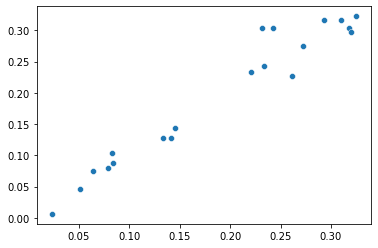

In [58]:
z = az.summary(az_data_bs_simple_mix, var_names=['d_base', 'k', 'mixing', 'k_contaminant','mu_contaminant'])
# print(params["d_base"])
sns.scatterplot(x = params["d_base"], y = sigmoid(z["mean"][0:N])/3.)

In [59]:
z

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base[0],-0.480,0.208,-0.876,-0.103,0.005,0.004,1615.0,1545.0,1.00
d_base[1],2.315,0.631,1.263,3.547,0.017,0.013,1485.0,1386.0,1.00
d_base[2],-0.473,0.252,-0.933,0.003,0.007,0.005,1378.0,1325.0,1.00
d_base[3],-0.792,0.301,-1.366,-0.271,0.010,0.007,912.0,1116.0,1.00
d_base[4],-0.276,0.304,-0.833,0.304,0.010,0.007,990.0,1296.0,1.00
d_base[5],0.856,0.400,0.116,1.610,0.015,0.010,726.0,1189.0,1.00
d_base[6],1.538,0.653,0.505,2.890,0.024,0.018,859.0,848.0,1.00
d_base[7],-3.958,0.519,-4.918,-3.095,0.014,0.010,1740.0,1352.0,1.00
d_base[8],2.986,0.905,1.327,4.603,0.021,0.016,1959.0,1348.0,1.00
d_base[9],2.336,0.894,0.841,4.120,0.030,0.022,1033.0,1057.0,1.00


<AxesSubplot:xlabel='yhat'>

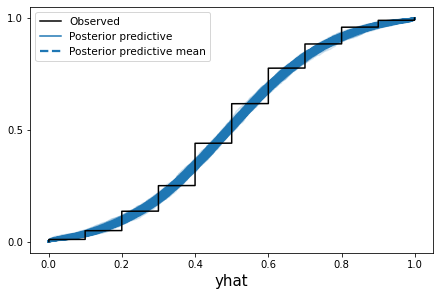

In [61]:
az.plot_ppc(az_data_bs_simple_mix, kind="cumulative")

## Summary so far 2021-06-23

When we are not worried about rounding, then it looks like things are actually pretty robust even without the mixture modeling. Failing to account for mixture of contaminants returns biased estimate of $k$ and inflates errors in estimates of $d$, but the $d$ estimates appear unbiased. So, we could conclude the mixture model is preferred but not strictly required.

Now to see what happens when substantial rounding is happening. Looks like it will be the same story but perhaps with posterior variance inflated even further? Next, I'll try adding the rounding stuff to the contaminant model.

Trying to model the rounding ruins everything more or less, so I actually think that's a big mistake!

__But what if we decrease $k$ to make the data noisier?__

In [ ]:
def bayesian_sampler_complex(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter

    # subject-level parameters/priors 
    with numpyro.plate("subj", n_Ps):
#        betas = numpyro.sample("beta", dist.Uniform(0.0, 1.0)) # bounded to [0,1] as in paper
#        N_deltas = numpyro.sample("N_delta", dist.Normal(0,3)) # 3/25/21, 11:10 PM changed this
#        N_primes = numpyro.sample("N_prime", dist.Normal(0,3))
        d_bases = numpyro.sample("d_base", dist.Normal(0, 1))
        d_deltas = numpyro.sample("d_delta", dist.Normal(0, 1)) # sum of these is approx uniform
        
    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
#    beta = betas[subj] # use jnp.exp() if unbounded
    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]
#     N = 1 + N_primes[subj] + N_deltas[subj] * not_conjdisj 
#    N_lin = N_primes[subj] + N_deltas[subj] * not_conjdisj #  < -------------- gah, fix this 3/26/21, 9:41 AM
#    N = 1 + jnp.exp(N_lin) # they required N be at least 1
    d_lin = d_bases[subj] + jnp.exp(d_deltas[subj]) * conjdisj # constrain d < d'
    d = sigmoid(d_lin)/3. # require this be below .33
    
    p_bs = prob_judge_BS_d(theta, X_num, X_denom, d)
    
    # Likelihood
    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)
    
    return yhat


In [ ]:
mcmc_bs = MCMC(NUTS(bayesian_sampler_complex, target_accept_prob=.80), 
               num_warmup=1000, 
               num_samples=1000, 
               num_chains=1)

mcmc_bs.run(random.PRNGKey(0), X_data, y_data)

In [ ]:
mcmc_bs.print_summary()

In [ ]:
import arviz as az

numpyro_data = az.from_numpyro(mcmc_bs)

az.waic(numpyro_data)

Posterior samples for $N$ and $\beta$ are highly correlated but they are still fairly well-identified, with the means getting the right answers.

Combining $N$ and $\beta$ to calculate $D$ shows that this is also correct.

In [ ]:
# can combine to form D
beta_post = numpyro_data.posterior.beta
N_post = numpyro_data.posterior.N_delta + numpyro_data.posterior.N_prime

d_post = beta_post/(N_post+2*beta_post)

az.plot_dist(d_post)
print("true d = ", .5/(16+1))

# PT+N simulations

This isn't quite working, I can't seem to get the parameters back out.

In [ ]:

params_ptn = {
    "d_base": {k: .03 for k in range(0,n_participants)},
    "d_delta": {k: .2 for k in range(0,n_participants)},
    "k":40
}

def calc_ptnprob(trial, theta, d):
    
    if is_cond(trial):
        X_num = num_vecs[trial]
        X_denom = denom_vecs[trial]
        X_A = pA_vecs[trial]
        
        p_numerator = np.sum(theta*X_num, axis=-1) #  = P(A & B)
        pA = np.sum(theta*X_A, axis=-1)
        num_or_denom = np.logical_or(X_A, X_denom).astype("float32")
        p_num_or_denom = np.sum(theta * num_or_denom , axis=-1) # = P(A or B)


        p_denom = np.sum(theta*X_denom, axis=-1)
        numerator = (p_numerator)*(1-2*d)**2 + d*(1-2*d)*(pA + p_denom) + d**2
        denom = ((1 - 2*d)*p_denom  + d)
        p_ptn = numerator/denom

        return p_ptn

    else:
        X_num = num_vecs[trial]
        X_denom = denom_vecs[trial]

        numerator = np.sum(theta*X_num, axis=-1)
        denom = np.sum(theta*X_denom, axis=-1)
        pi = np.divide(numerator, denom)
        p_ptn = (1 - 2*d)*pi  + d

        return p_ptn

def sim_PTN(trial_types, n_participants, n_blocks, params):

    n_trial_types = len(trial_types)
    trials = trial_types*n_blocks
    conds = np.tile(np.arange(0,n_blocks).repeat(len(trial_types)), n_participants)
    blocks = list(np.repeat(np.array(list(range(0, n_blocks))), n_trial_types))

    all_participants = list(np.repeat(np.array(list(range(0, n_participants))), n_trial_types*n_blocks))
    all_thetas = make_thetas(n_participants)
    all_trials = trials*n_participants
    all_blocks = blocks*n_participants

    sim_data = pd.DataFrame(
        data = {
            "ID": all_participants,
            "querytype": all_trials, 
            "block": all_blocks,
            "coldrainy": conds
        }) >> mutate(
            conjdisj_trial = X.querytype.apply(is_conjdisj),
            cond_trial = X.querytype.apply(is_cond),
            d_base = X.ID.apply(lambda x: params["d_base"][x]),
            d_delta = X.ID.apply(lambda x: params["d_delta"][x]),
        theta = X.ID.apply(lambda x: all_thetas[x])
        ) >> mutate(d = X.d_base + X.d_delta * X.conjdisj_trial)

    sim_data["prob"] = sim_data.apply(lambda x: calc_ptnprob(x.querytype, x.theta, x.d), axis=1)
    sim_data["estimate"] = sim_data.prob.apply(lambda x: np.random.beta(x*params["k"], (1-x)*params["k"]))
#     sim_data["estimate"] = sim_data.apply(lambda x: sim_sampling(x.prob, x.beta, x.N, params["k"]), axis=1)
    
    return sim_data

sim_data2 = sim_PTN(trial_types, 1, 10, params_ptn)
X_data, y_data = make_model_data(sim_data2) # see data_helpers.py

In [ ]:
# sim_data2
calc_ptnprob("AandB",np.array([.3,.2,.1,.4]), .1)


In [ ]:
def prob_judge_PTN(trial, theta, X_num, X_denom, X_A, d):
    conditional = jnp.array([is_cond(i) for i in trial])
    not_conditional = abs(1-conditional)
    p_numerator = jnp.sum(theta*X_num, axis=-1) #  = P(A & B)
    pA = jnp.sum(theta*X_A, axis=-1)
    num_or_denom = jnp.logical_or(X_A, X_denom).astype("float32")
    p_num_or_denom = jnp.sum(theta * num_or_denom , axis=-1) # = P(A or B)


    p_denom = jnp.sum(theta*X_denom, axis=-1)
    numerator = ((p_numerator)*(1-2*d)**2 + d*(1-2*d)*(pA + p_denom) + d**2)*conditional + ((1 - 2*d)*p_numerator + d)*not_conditional
    denom = ((1 - 2*d)*p_denom  + d)*conditional + p_denom*not_conditional
    
    return jnp.divide(numerator, denom) # move division to after noise is added

def PTN_complex(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    X_A = jnp.stack([pA_vecs[i] for i in trial])
    
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter

    # Subject-level parameters/priors
    with numpyro.plate("subj", n_Ps):
        d_bases = numpyro.sample("d_base", dist.Normal(0, 2))
        d_deltas = numpyro.sample("d_delta", dist.Normal(0, .2))
        
    # Subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    d_lin = d_bases[subj] + jnp.exp(d_deltas[subj]) * conjdisj # constrain d' > d
#     d_lin = d_bases[subj]*not_conjdisj + d_deltas[subj]*conjdisj
    d = sigmoid(d_lin)/2. # require this be below .50
    
    theta_ind = (subj*2) + cond
    theta = thetas[theta_ind,:]
    
    p_ptn = prob_judge_PTN(trial, theta, X_num, X_denom, X_A, d)

    # Likelihood
    with numpyro.plate("data", len(trial)):
#         yhat = numpyro.sample("yhat", dist.Normal(p_ptn, sigma), obs = y) # wrong but replicates paper
        yhat = numpyro.sample("yhat", dist.Beta(p_ptn*k, (1-p_ptn)*k), obs=y)
    
    return yhat

In [ ]:
mcmc_ptn = MCMC(NUTS(PTN_complex, target_accept_prob=.80), 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=1)

mcmc_ptn.run(random.PRNGKey(0), X_data, y_data)

In [ ]:
mcmc_ptn.print_summary()

3/24/21, 4:58 PM: Working! (earlier problem was simulation bug)

# Mixture models

Here is a simple mixture model with some outliers based on this blog post: https://dfm.io/posts/mixture-models/

In [ ]:
import numpy as np
import matplotlib.pyplot as pl

# We'll choose the parameters of our synthetic data.
# The outlier probability will be 80%:
true_frac = 0.8

# The linear model has unit slope and zero intercept:
true_params = [1.0, 0.0]

# The outliers are drawn from a Gaussian with zero mean and unit variance:
true_outliers = [0.0, 1.0]

# For reproducibility, let's set the random number seed and generate the data:
np.random.seed(12)
x = np.sort(np.random.uniform(-2, 2, 15))
yerr = 0.2 * np.ones_like(x)
y = true_params[0] * x + true_params[1] + yerr * np.random.randn(len(x))

# Those points are all drawn from the correct model so let's replace some of
# them with outliers.
m_bkg = np.random.rand(len(x)) > true_frac
y[m_bkg] = true_outliers[0]
y[m_bkg] += np.sqrt(true_outliers[1]+yerr[m_bkg]**2) * np.random.randn(sum(m_bkg))

In [ ]:
# First, fit the data and find the maximum likelihood model ignoring outliers.
A = np.vander(x, 2)
p = np.linalg.solve(np.dot(A.T, A / yerr[:, None]**2), np.dot(A.T, y / yerr**2))

# Then save the *true* line.
x0 = np.linspace(-2.1, 2.1, 200)
y0 = np.dot(np.vander(x0, 2), true_params)

# Plot the data and the truth.
pl.errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
pl.scatter(x[m_bkg], y[m_bkg], marker="s", s=22, c="w", zorder=1000)
pl.scatter(x[~m_bkg], y[~m_bkg], marker="o", s=22, c="k", zorder=1000)
pl.plot(x0, y0, color="k", lw=1.5)

# Plot the best fit line.
pl.plot(x0, x0 * p[0] + p[1], color="#8d44ad", lw=3, alpha=0.5)

pl.xlabel("$x$")
pl.ylabel("$y$")
pl.ylim(-2.5, 2.5)
pl.xlim(-2.1, 2.1);

In [ ]:
from numpy.random import default_rng

def round_to_one(x):
    return jnp.round(x,0)

def round_to_five(x):
    return jnp.round(x/5,0)*5

def round_to_twenty(x):
    return jnp.round(x/20,0)*20

n_obs = 500
rg = default_rng(12345)

x = rg.normal(0,1,n_obs)
bad = rg.binomial(1, 1, n_obs)
y_true = rg.normal(0 + .75*x, .5, n_obs)
# y_obs = np.select([bad==0, bad==1], [round_to_one(y_true), round_to_twenty(y_true)])
y_obs = np.select([bad==0,bad==1], [y_true, round_to_one(y_true)])

sns.scatterplot(x, y_obs, hue=bad,alpha=.25)
# sns.histplot(y_obs,bins=50)

# from numpy.random import default_rng

# def round_to_one(x):
#     return jnp.round(x,0)

# def round_to_five(x):
#     return jnp.round(x/5,0)*5

# def round_to_ten(x):
#     return jnp.round(x/10,0)*10

# n_obs = 1000
# rg = default_rng(12345)

# x = rg.normal(0,1,n_obs)
# bad = rg.binomial(2, .8, n_obs)
# y_true = rg.normal(.5 + 1*x, .3, n_obs)*100
# y_obs = np.select([bad==0, bad==1, bad==2], [round_to_one(y_true), round_to_five(y_true), round_to_ten(y_true)])
                   

# sns.scatterplot(x, y_obs, hue=bad, alpha=.5)

In [ ]:
# def round_to_one(x):
#     return jnp.round(x,0)

# this works and is the most clear, but seems sensitive to how sigma_rnd is set and idk what the right setting is in principle
# needs DiscreteHMCGibbs()
# @config_enumerate
def roundmodel(x, y=None):
    
    alpha = numpyro.sample("alpha", dist.Normal(0,10))
    beta = numpyro.sample("beta", dist.Normal(0,10))
    sd_true = numpyro.sample("sd_true", dist.HalfCauchy(10))
#     sigma_rnd = numpyro.sample("sigma_rnd", dist.HalfCauchy(.1))

    p_round = numpyro.sample("p_outlier", dist.Dirichlet(jnp.ones(2)/2))
    mu_true = alpha + beta*x

    with numpyro.plate("data", x.shape[0]):
        y_true = numpyro.sample("y_true", dist.Normal(mu_true, sd_true))
        z = numpyro.sample("z", dist.Categorical(p_round))
        yhat = jnp.select([z==0, z==1], [y_true, round_to_one(y_true)])
        numpyro.sample("yhat", dist.Normal(yhat, .001), obs=y)

# ## not clear how to make this work if there are multiple forms of rounding going on.        
# def roundmodel(x, y=None):
    
#     alpha = numpyro.sample("alpha", dist.Normal(0,10))
#     beta = numpyro.sample("beta", dist.Normal(0,10))
#     sigma = numpyro.sample("sigma", dist.HalfCauchy(10))
    
#     with numpyro.plate("data", x.shape[0]):
#         y_err = numpyro.sample("y_err", dist.Beta(1,1))
#         y_fore = alpha + beta*x
#         y_latent = numpyro.sample("y_latent", dist.Normal(y_fore, sigma))
#         numpyro.sample("yhat", dist.Normal(y_latent + (y_err-.5), .01), obs=y)

In [ ]:
kernel = DiscreteHMCGibbs(NUTS(roundmodel), modified=True)
# kernel = NUTS(roundmodel)
mcmc_test = MCMC(kernel, 4000, 2000)

mcmc_test.run(random.PRNGKey(0), x, y_obs)
# mcmc_test.print_summary()

In [ ]:
mcmc_test.print_summary()

In [ ]:
az_data = make_arviz_data(mcmc_test, roundmodel, x)

In [ ]:
az.plot_ppc(data=az_data, data_pairs={"yhat":"yhat"}, num_pp_samples=500, figsize=(10,10))

In [ ]:

## this is gelman's approach and it works the best
## but not clear how to make this work if there are multiple forms of rounding going on.        
def roundmodel(x, y=None):
    
    alpha = numpyro.sample("alpha", dist.Normal(0,10))
    beta = numpyro.sample("beta", dist.Normal(0,10))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(10))
    
    with numpyro.plate("data", x.shape[0]):
        y_err = numpyro.sample("y_err", dist.Beta(1,1))
        y_fore = alpha + beta*x
        y_latent = numpyro.sample("y_latent", dist.Normal(y_fore, sigma))
        numpyro.sample("yhat", dist.Normal(y_latent + (y_err-.5), .01), obs=y)

# def roundmodel(x, y=None):
    
#     alpha = numpyro.sample("alpha", dist.Normal(0,10))
#     beta = numpyro.sample("beta", dist.Normal(0,10))
#     sigma = numpyro.sample("sigma", dist.HalfCauchy(10))

# #     err_mult = jnp.array([1., 20])

#     with numpyro.plate("data", x.shape[0]):
#         err_type_p = numpyro.sample("err_type_p", dist.Dirichlet(jnp.ones(2)))
#         err_type = numpyro.sample("z", dist.Categorical(err_type_p))
# #         err_mult = jnp.matmul(jnp.array([1,20]), err_type_p)
#         y_err = numpyro.sample("y_err", dist.Beta(1,1))
#         y_fore = alpha + beta*x
#         y_latent = numpyro.sample("y_latent", dist.Normal(y_fore, sigma))
#         numpyro.sample("yhat", dist.Normal(y_latent + (y_err-.5)*err_mult, .01), obs=y)


# def roundmodel(x, y=None):
#     y_true = numpyro.sample("y_true", dist.Normal(mu_true, sd_true))
#     mu_true = ...
#     y_obs = heaping_func(y_true, params)
    

In [ ]:
kernel = NUTS(roundmodel)
mcmc_test = MCMC(kernel, 2000, 2000)

mcmc_test.run(random.PRNGKey(0), x, y_obs)
mcmc_test.print_summary()

In [ ]:
kernel = DiscreteHMCGibbs(NUTS(roundmodel), modified=True)
kernel = NUTS(roundmodel)
mcmc_test = MCMC(kernel, 2000, 2000)

mcmc_test.run(random.PRNGKey(0), x, y_obs)
mcmc_test.print_summary()